### Importação das Bibliotecas

In [28]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scikeras.wrappers import KerasRegressor

from keras.models import Sequential
from keras.layers import Input, LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from keras.metrics import RootMeanSquaredError

In [29]:
def create_sequences_uni(data=[], seq_len=7):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

In [ ]:
def create_lstm_model(seq_len=14, n_features=1, neurons=100, drop=0.2, optimizer='Adam'):
  model = Sequential([
      Input(shape=(seq_len, n_features)),
      LSTM(neurons, return_sequences=True),
      Dropout(drop),
      LSTM((neurons//2), return_sequences=False),
      Dropout(drop),
      Dense(1),
  ])
  model.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError()])
  return model

param_grid = {
                # 'model__neurons': [32, 64, 96],
                # 'model__drop': [0.1, 0.2, 0.3],
                # 'model__optimizer': ['Adam'], 
                # 'fit__batch_size': [16, 32],   
                # 'fit__epochs': [50, 100],
                'model__neurons': [60],
                'model__drop': [0.1],
                'model__optimizer': ['Adam'], 
                'fit__batch_size': [16],   
                'fit__epochs': [100],
              }

In [ ]:
models_lstm_all = []
models_lstm_cropped = []
models_lstm_lag = []
# seq_len_options = [7, 14, 30]
seq_len_options = [14]
# split_options = [5, 10]
split_options = [5]

event_date = pd.Timestamp('2024-11-05') 
event_label = "Trump Elected"

### Modelo com dado completo

In [32]:
data = pd.read_csv('../data/processed/BTC-USD_all.csv', index_col='Date', parse_dates=True)
data.head(5)

,Close,High,Low,Open,Volume
Date,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100


In [33]:
serie = data['Close']

train_size = int(0.8 * len(serie))
train_data = serie[:train_size].values.reshape(-1, 1)
test_data = serie[train_size:].values.reshape(-1, 1)

scaler_all = MinMaxScaler(feature_range=(0,1))
data_train_scaled = scaler_all.fit_transform(train_data)
data_test_scaled = scaler_all.transform(test_data)

In [34]:
for seq_len in seq_len_options:
  print(f"===== JANELA DE {seq_len} =====")

  X_train_scaled, y_train_scaled = create_sequences_uni(data_train_scaled, seq_len)
  X_test_scaled, y_test_scaled = create_sequences_uni(data_test_scaled, seq_len)

  for split in split_options:
    print(f"_____ SPLIT DE {split} _____")

    model = KerasRegressor(model=create_lstm_model, verbose=0, seq_len=seq_len, n_features=X_train_scaled.shape[2])

    tscv = TimeSeriesSplit(n_splits=split)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, refit=True, scoring="neg_root_mean_squared_error", n_jobs = -1)

    early_stopping = EarlyStopping(monitor='val_root_mean_squared_error', patience=10, restore_best_weights=True)

    grid_result_all = grid.fit(X_train_scaled, y_train_scaled, callbacks=[early_stopping], validation_split=0.2)

    models_lstm_all.append({
      "model": grid_result_all.best_estimator_,
      "params": grid_result_all.best_params_,
      "rmse": -grid_result_all.best_score_,
      "n_splits": split,
      "seq_len": seq_len,
      "X_test": X_test_scaled,
      "y_test": y_test_scaled,
      "type": "Univariado",
      "algorithm": "LSTM"
    })
    
    print(f"Menor RMSE: {-grid_result_all.best_score_:.3f} usando: {grid_result_all.best_params_}")

===== JANELA DE 7 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.016 usando: {'fit__batch_size': 32, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 64, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.013 usando: {'fit__batch_size': 32, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 96, 'model__optimizer': 'Adam'}
===== JANELA DE 14 =====
_____ SPLIT DE 5 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.015 usando: {'fit__batch_size': 16, 'fit__epochs': 50, 'model__drop': 0.2, 'model__neurons': 96, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

Detailed tracebacks of the workers should have been printed to stderr in the executor process if faulthandler was not disabled.

#### Resultados


In [ ]:
for m in models_lstm_all:
    y_pred = m["model"].predict(m["X_test"])
    rmse_test = np.sqrt(mean_squared_error(m["y_test"], y_pred))
    m["rmse_test"] = rmse_test

lstm_all_ordered_by_test = sorted(models_lstm_all, key=lambda x: x["rmse_test"])

for i, obj in enumerate(lstm_all_ordered_by_test):
    print(f"--- Modelo {i+1} ---")
    print("params:", obj.get("params"))
    print("rmse_test:", obj.get("rmse_test"))
    print("n_splits:", obj.get("n_splits"))
    print("seq_len:", obj.get("seq_len"))
    print()

In [ ]:
y_pred_scaled = lstm_all_ordered_by_test[0]["model"].predict(lstm_all_ordered_by_test[0]["X_test"])

rmse = np.sqrt(mean_squared_error(lstm_all_ordered_by_test[0]["y_test"], y_pred_scaled))
mae = mean_absolute_error(lstm_all_ordered_by_test[0]["y_test"], y_pred_scaled)

print(f"MAE normalizado: {mae}")
print(f"RMSE normalizado: {rmse}")

y_pred = scaler_all.inverse_transform(y_pred_scaled)
y_test = scaler_all.inverse_transform(lstm_all_ordered_by_test[0]["y_test"])

MAE normalizado: 0.057215762744045974
RMSE normalizado: 0.07819884928332299


In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"MAE real: {mae}")
print(f"RMSE real: {rmse}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.2f}")

MAE real: 3855.698683578745
RMSE real: 5269.72260198702
MAPE: 4.58%
R²: 0.96


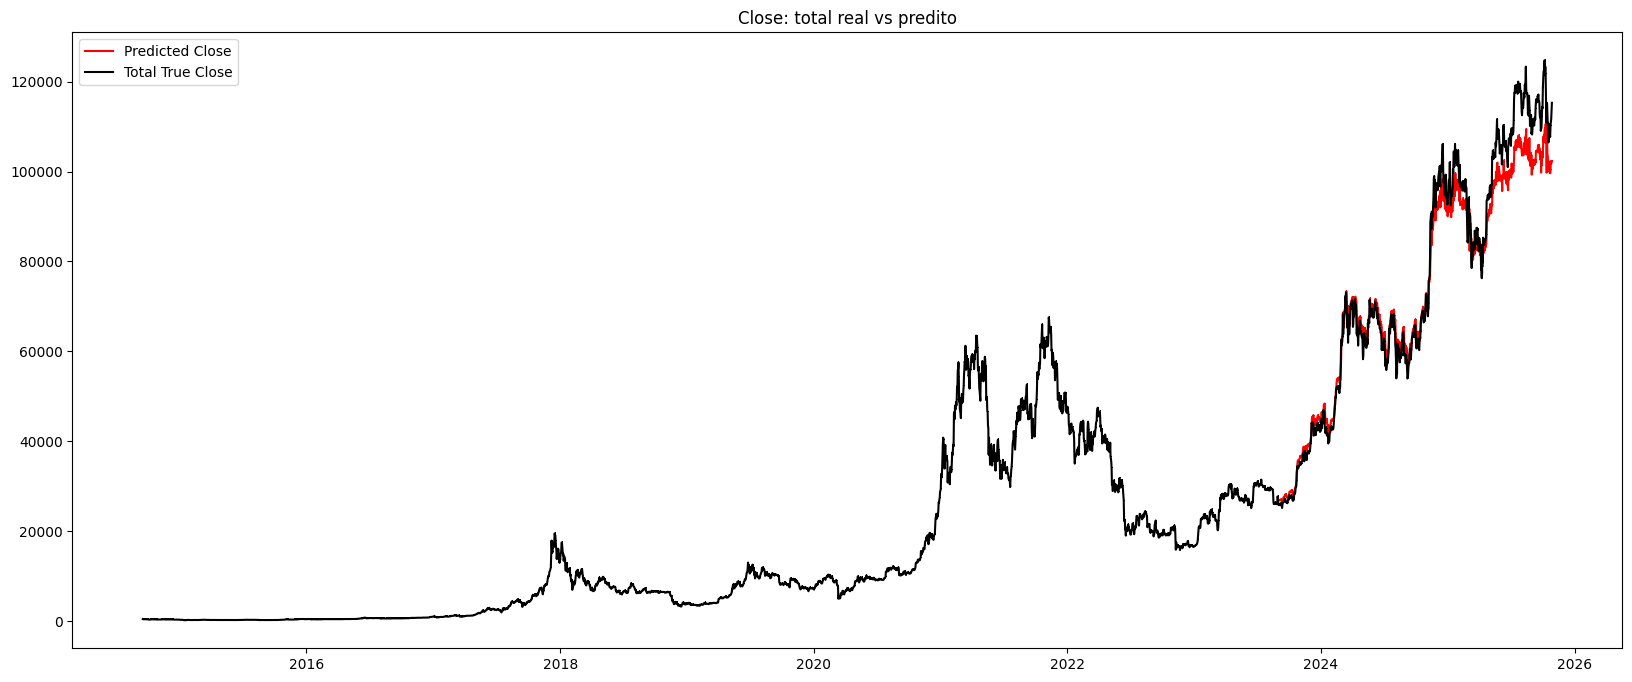

In [ ]:
y_pred_plot = np.empty_like(data['Close'])
y_pred_plot[:] = np.nan
y_pred_plot[-len(y_pred):] = y_pred.reshape(-1)

plt.figure(figsize=(20,8))
plt.plot(data.index, y_pred_plot, color="red", marker=",", label='Predicted Close')
plt.plot(data.index, np.array(data['Close']), color="black", marker=",", label='Total True Close')
plt.title('Close: total real vs predito')
plt.legend()
plt.show()

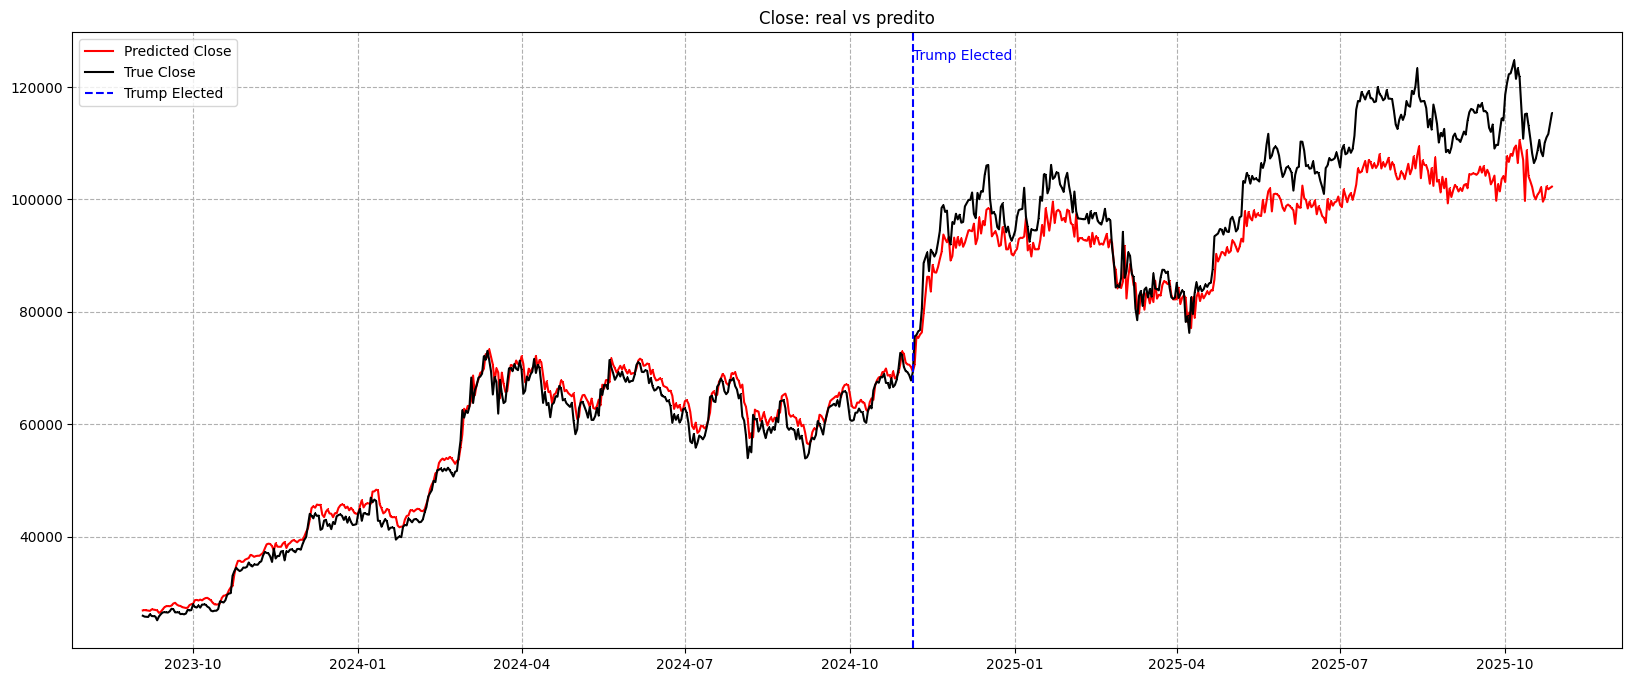

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(data.index[-len(y_pred):], y_pred, color="red", marker=",", label='Predicted Close')
plt.plot(data.index[-len(y_test):], y_test, color="black", marker=",", label='True Close')
plt.axvline(x=event_date, color='blue', linestyle='--', label=event_label)
plt.text(event_date, max(data['Close']), event_label, color='blue')
plt.title('Close: real vs predito')
plt.legend()
plt.grid(True, linestyle="--")
plt.show()

### Modelo com dado cortado (inicio ate a moeda se estabilizar foi removido)

In [ ]:
data = pd.read_csv('../data/processed/BTC-USD_cropped.csv', index_col='Date', parse_dates=True)
data.head(5)

,Close,High,Low,Open,Volume
Date,,,,,
2017-01-01,998.325012,1003.080017,958.698975,963.658020,147775008
2017-01-02,1021.750000,1031.390015,996.702026,998.617004,222184992
2017-01-03,1043.839966,1044.079956,1021.599976,1021.599976,185168000
2017-01-04,1154.729980,1159.420044,1044.400024,1044.400024,344945984
2017-01-05,1013.380005,1191.099976,910.416992,1156.729980,510199008


In [ ]:
serie = data['Close']

train_size = int(0.8 * len(serie))
train_data = serie[:train_size].values.reshape(-1, 1)
test_data = serie[train_size:].values.reshape(-1, 1)

scaler_cropped = MinMaxScaler(feature_range=(0,1))
data_train_scaled = scaler_cropped.fit_transform(train_data)
data_test_scaled = scaler_cropped.transform(test_data)

In [ ]:
for seq_len in seq_len_options:
  print(f"===== JANELA DE {seq_len} =====")

  X_train_scaled, y_train_scaled = create_sequences_uni(data_train_scaled, seq_len)
  X_test_scaled, y_test_scaled = create_sequences_uni(data_test_scaled, seq_len)

  for split in split_options:
    print(f"_____ SPLIT DE {split} _____")

    model = KerasRegressor(model=create_lstm_model, verbose=0, seq_len=seq_len, n_features=X_train_scaled.shape[2])

    tscv = TimeSeriesSplit(n_splits=split)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, refit=True, scoring="neg_root_mean_squared_error", n_jobs = -1)

    early_stopping = EarlyStopping(monitor='val_root_mean_squared_error', patience=10, restore_best_weights=True)

    grid_result_cropped = grid.fit(X_train_scaled, y_train_scaled, callbacks=[early_stopping], validation_split=0.2)

    models_lstm_cropped.append({
      "model": grid_result_cropped.best_estimator_,
      "params": grid_result_cropped.best_params_,
      "rmse": -grid_result_cropped.best_score_,
      "n_splits": split,
      "seq_len": seq_len,
      "X_test": X_test_scaled,
      "y_test": y_test_scaled,
      "type": "Univariado",
      "algorithm": "LSTM"
    })
    
    print(f"Menor RMSE: {-grid_result_cropped.best_score_:.3f} usando: {grid_result_cropped.best_params_}")

===== JANELA DE 7 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.026 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 60, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____
Menor RMSE: 0.020 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 60, 'model__optimizer': 'Adam'}
===== JANELA DE 30 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.022 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 60, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____
Menor RMSE: 0.022 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 60, 'model__optimizer': 'Adam'}


#### Resultados

In [ ]:
for m in models_lstm_cropped:
    y_pred = m["model"].predict(m["X_test"])
    rmse_test = np.sqrt(mean_squared_error(m["y_test"], y_pred))
    m["rmse_test"] = rmse_test

lstm_cropped_ordered_by_test = sorted(models_lstm_cropped, key=lambda x: x["rmse_test"])

for i, obj in enumerate(lstm_cropped_ordered_by_test):
    print(f"--- Modelo {i+1} ---")
    print("params:", obj.get("params"))
    print("rmse_test:", obj.get("rmse_test"))
    print("n_splits:", obj.get("n_splits"))
    print("seq_len:", obj.get("seq_len"))
    print()

In [ ]:
y_pred_scaled = lstm_cropped_ordered_by_test[0]["model"].predict(lstm_cropped_ordered_by_test[0]["X_test"])

rmse = np.sqrt(mean_squared_error(lstm_cropped_ordered_by_test[0]["y_test"], y_pred_scaled))
mae = mean_absolute_error(lstm_cropped_ordered_by_test[0]["y_test"], y_pred_scaled)

print(f"MAE normalizado: {mae}")
print(f"RMSE normalizado: {rmse}")

y_pred = scaler_cropped.inverse_transform(y_pred_scaled)
y_test = scaler_cropped.inverse_transform(lstm_cropped_ordered_by_test[0]["y_test"])

MAE normalizado: 0.05176265542584529
RMSE normalizado: 0.06673923708621747


In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"MAE real: {mae}")
print(f"RMSE real: {rmse}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.2f}")

MAE real: 3457.1802855252445
RMSE real: 4457.452329894603
MAPE: 3.65%
R²: 0.96


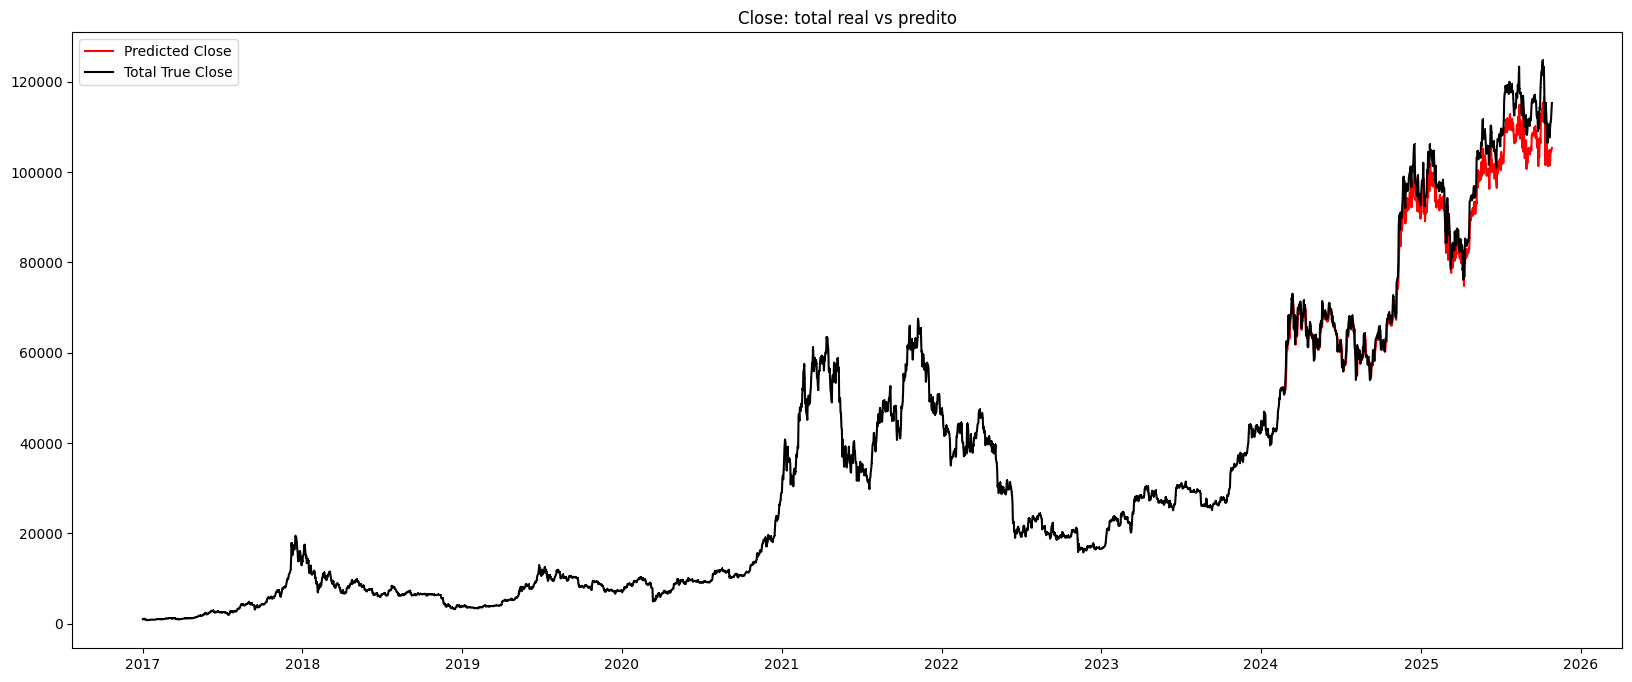

In [ ]:
y_pred_plot = np.empty_like(data['Close'])
y_pred_plot[:] = np.nan
y_pred_plot[-len(y_pred):] = y_pred.reshape(-1)

plt.figure(figsize=(20,8))
plt.plot(data.index, y_pred_plot, color="red", marker=",", label='Predicted Close')
plt.plot(data.index, np.array(data['Close']), color="black", marker=",", label='Total True Close')
plt.title('Close: total real vs predito')
plt.legend()
plt.show()

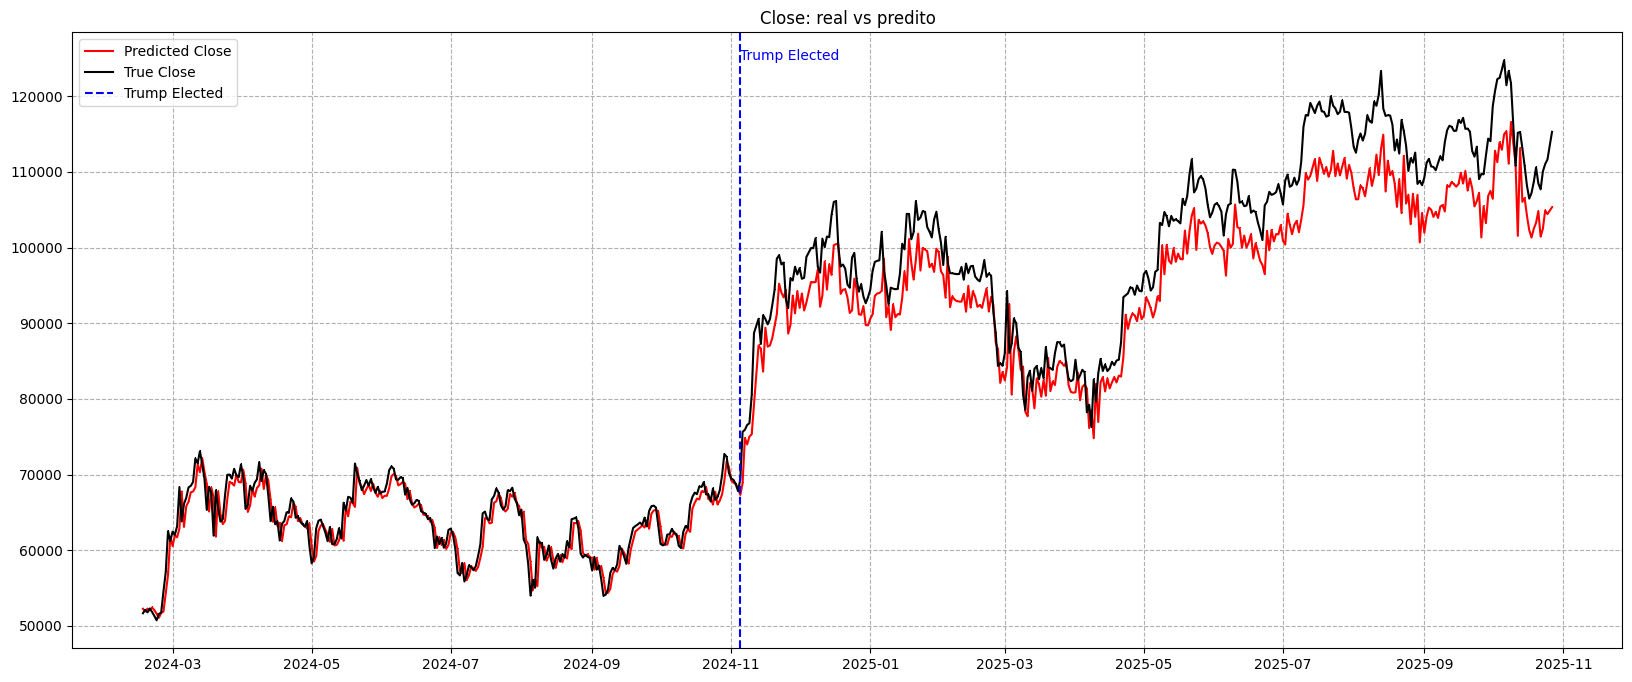

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(data.index[-len(y_pred):], y_pred, color="red", marker=",", label='Predicted Close')
plt.plot(data.index[-len(y_test):], y_test, color="black", marker=",", label='True Close')
plt.axvline(x=event_date, color='blue', linestyle='--', label=event_label)
plt.text(event_date, max(data['Close']), event_label, color='blue')
plt.title('Close: real vs predito')
plt.legend()
plt.grid(True, linestyle="--")
plt.show()

5 de novembro donald trump foi eleito presidente

### Modelo com lag nos dados

In [ ]:
data = pd.read_csv('../data/processed/BTC-USD_lag_cropped.csv', index_col='Date', parse_dates=True)
data.head(5)

,Close,High,Low,Open,Volume,closeLag_1,closeLag_2,closeLag_3,closeLag_4,closeLag_5,...,closeLag_21,closeLag_22,closeLag_23,closeLag_24,closeLag_25,closeLag_26,closeLag_27,closeLag_28,closeLag_29,closeLag_30
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,998.325012,1003.080017,958.698975,963.658020,147775008,963.742981,961.237976,973.497009,975.921021,933.197998,...,769.731018,774.650024,772.794006,770.809998,768.132019,764.223999,758.700012,773.872009,771.155029,777.943970
2017-01-02,1021.750000,1031.390015,996.702026,998.617004,222184992,998.325012,963.742981,961.237976,973.497009,975.921021,...,780.086975,769.731018,774.650024,772.794006,770.809998,768.132019,764.223999,758.700012,773.872009,771.155029
2017-01-03,1043.839966,1044.079956,1021.599976,1021.599976,185168000,1021.750000,998.325012,963.742981,961.237976,973.497009,...,780.556030,780.086975,769.731018,774.650024,772.794006,770.809998,768.132019,764.223999,758.700012,773.872009
2017-01-04,1154.729980,1159.420044,1044.400024,1044.400024,344945984,1043.839966,1021.750000,998.325012,963.742981,961.237976,...,781.481018,780.556030,780.086975,769.731018,774.650024,772.794006,770.809998,768.132019,764.223999,758.700012
2017-01-05,1013.380005,1191.099976,910.416992,1156.729980,510199008,1154.729980,1043.839966,1021.750000,998.325012,963.742981,...,778.088013,781.481018,780.556030,780.086975,769.731018,774.650024,772.794006,770.809998,768.132019,764.223999


In [ ]:
train_size = int(0.8 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

scaler_lag = MinMaxScaler(feature_range=(0, 1))
scaler_lag.fit(train_data)

data_train_normalized = pd.DataFrame(
    scaler_lag.transform(train_data),
    columns=data.columns,
    index=train_data.index
)

data_test_normalized = pd.DataFrame(
    scaler_lag.transform(test_data),
    columns=data.columns,
    index=test_data.index
)

scaler_close = MinMaxScaler(feature_range=(0, 1))
scaler_close.fit(train_data[['Close']]) 

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [ ]:
for seq_len in seq_len_options:
  print(f"===== JANELA DE {seq_len} =====")

  feature_cols = ['Close'] + [f'closeLag_{i}' for i in range(1, seq_len)]
  target_col = f'closeLag_{seq_len}'

  X_train_scaled = data_train_normalized[feature_cols].values
  y_train_scaled = data_train_normalized[target_col].values

  X_test_scaled = data_test_normalized[feature_cols].values
  y_test_scaled = data_test_normalized[target_col].values

  X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
  X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

  for split in split_options:
    print(f"_____ SPLIT DE {split} _____")

    model = KerasRegressor(model=create_lstm_model, verbose=0, seq_len=seq_len, n_features=X_train_scaled.shape[2])

    tscv = TimeSeriesSplit(n_splits=split)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, refit=True, scoring="neg_root_mean_squared_error", n_jobs = -1)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    grid_result_lag = grid.fit(X_train_scaled, y_train_scaled, callbacks=[early_stopping], validation_split=0.2)

    models_lstm_lag.append({
      "model": grid_result_lag.best_estimator_,
      "params": grid_result_lag.best_params_,
      "rmse": -grid_result_lag.best_score_,
      "n_splits": split,
      "seq_len": seq_len,
      "X_test": X_test_scaled,
      "y_test": y_test_scaled,
      "type": "Univariado",
      "algorithm": "LSTM"
    })
    
    print(f"Menor RMSE: {-grid_result_lag.best_score_:.3f} usando: {grid_result_lag.best_params_}")

===== JANELA DE 7 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.120 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 60, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____
Menor RMSE: 0.078 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.2, 'model__neurons': 60, 'model__optimizer': 'Adam'}
===== JANELA DE 30 =====
_____ SPLIT DE 5 _____
Menor RMSE: 0.105 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 40, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.074 usando: {'fit__batch_size': 16, 'fit__epochs': 100, 'model__drop': 0.1, 'model__neurons': 60, 'model__optimizer': 'Adam'}


#### Resultados

In [ ]:
for m in models_lstm_lag:
    y_pred = m["model"].predict(m["X_test"])
    rmse_test = np.sqrt(mean_squared_error(m["y_test"], y_pred))
    m["rmse_test"] = rmse_test

lstm_lag_ordered_by_test = sorted(models_lstm_lag, key=lambda x: x["rmse_test"])

for i, obj in enumerate(lstm_lag_ordered_by_test):
    print(f"--- Modelo {i+1} ---")
    print("params:", obj.get("params"))
    print("rmse_test:", obj.get("rmse_test"))
    print("n_splits:", obj.get("n_splits"))
    print("seq_len:", obj.get("seq_len"))
    print()

In [ ]:
y_pred_scaled = lstm_lag_ordered_by_test[0]["model"].predict(lstm_lag_ordered_by_test[0]["X_test"])

rmse = np.sqrt(mean_squared_error(lstm_lag_ordered_by_test[0]["y_test"], y_pred_scaled))
mae = mean_absolute_error(lstm_lag_ordered_by_test[0]["y_test"], y_pred_scaled)

print(f"MAE normalizado: {mae}")
print(f"RMSE normalizado: {rmse}")

y_pred = scaler_close.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test = scaler_close.inverse_transform(lstm_lag_ordered_by_test[0]["y_test"].reshape(-1, 1))

y_pred = y_pred.flatten()
y_test = y_test.flatten()

MAE normalizado: 0.19003596189036892
RMSE normalizado: 0.26306459192145953


In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

print(f"MAE real: {mae}")
print(f"RMSE real: {rmse}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.2f}")

MAE real: 12692.326147612577
RMSE real: 17569.840409746117
MAPE: 12.56%
R²: 0.38


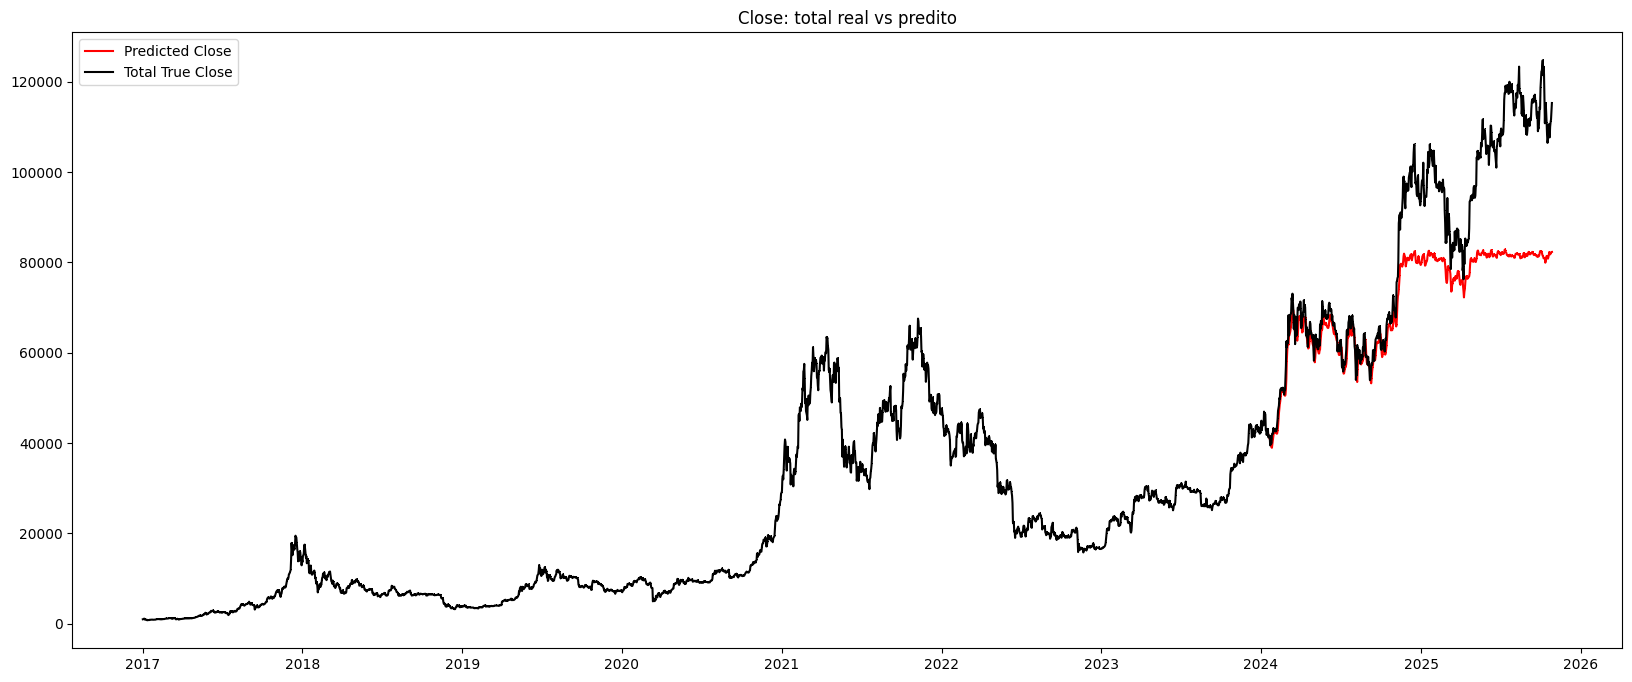

In [ ]:
y_pred_plot = np.empty_like(data['Close'])
y_pred_plot[:] = np.nan
y_pred_plot[-len(y_pred):] = y_pred.reshape(-1)

plt.figure(figsize=(20,8))
plt.plot(data.index, y_pred_plot, color="red", marker=",", label='Predicted Close')
plt.plot(data.index, np.array(data['Close']), color="black", marker=",", label='Total True Close')
plt.title('Close: total real vs predito')
plt.legend()
plt.show()

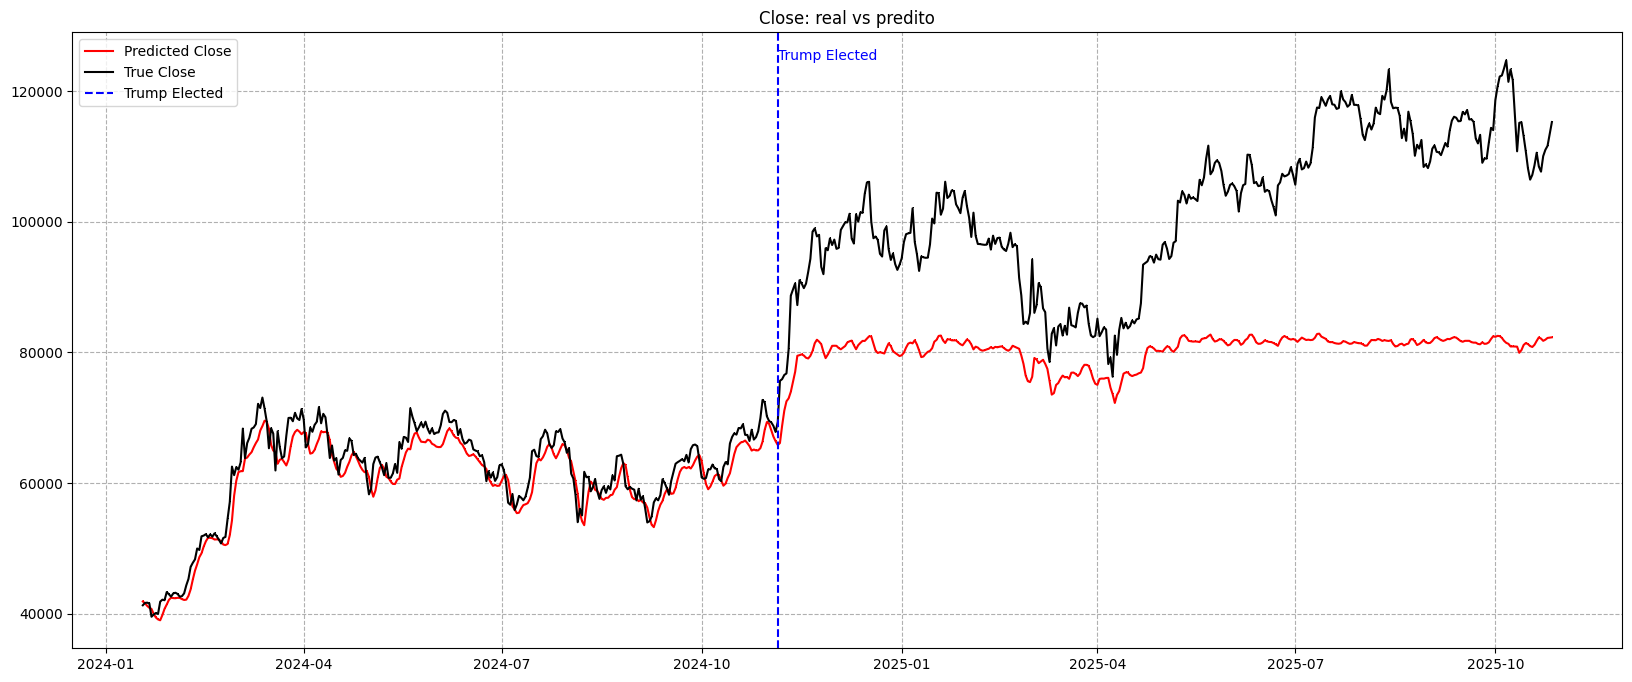

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(data.index[-len(y_pred):], y_pred, color="red", marker=",", label='Predicted Close')
plt.plot(data.index[-len(y_test):], y_test, color="black", marker=",", label='True Close')
plt.axvline(x=event_date, color='blue', linestyle='--', label=event_label)
plt.text(event_date, max(data['Close']), event_label, color='blue')
plt.title('Close: real vs predito')
plt.legend()
plt.grid(True, linestyle="--")
plt.show()